<a href="https://colab.research.google.com/github/tanmaylaud/Patient_Conversation_Classifier_FastAI/blob/master/Patient_Conversation_Classifier_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *
import pandas as pd

In [0]:
path = Path('data')

In [0]:
df = pd.read_csv(path/'test.csv',encoding= 'unicode_escape')
df[['TRANS_CONV_TEXT']].to_csv(path/'test_processed.csv',index=False)

In [0]:
df = pd.read_csv(path/'train.csv',encoding= 'unicode_escape')
df=df[['TRANS_CONV_TEXT','Patient_Tag']]
df=df.dropna()
df.to_csv(path/'train_processed.csv',index=False)

In [6]:
data = TextLMDataBunch.from_csv(path=path, csv_name='train_processed.csv',
                                test='test_processed.csv',text_cols='TRANS_CONV_TEXT',
                                label_cols='Patient_Tag',
                                )
data.show_batch()

idx,text
0,"xxup gp ordered it without me asking . xxmaj heart failure , severe weakness , constant angina , xxup bp can down xxunk drastically , suspected xxup xxunk / xxup xxunk , xxunk heart up to 350 down to 4 within xxunk , falls , xxunk , swollen red painful knees , vertigo etc .. could not go walking about without wheelchair . if they can walk with an aid"
1,"pumps , xxmaj ferrari and colleagues linked numerous dox molecules to stringlike molecules called polymers . xxmaj they then infused the dox - carrying polymers into their silicon microparticles and injected them into mice that had been implanted with human metastatic liver and lung tumors . xxmaj as with the previous studies , the researchers found that the silicon particles xxunk in and around tumor sites , and once there"
2,"/ celebrity - news / xxunk - gareth - xxunk xxbos a xxmaj wind xxmaj chill xxmaj advisory will be in effect from 10 tonight , until 10 xxmaj sunday morning . xxmaj columbia xxmaj gas service has been fully restored to western xxmaj sandusky and xxmaj bay xxmaj view . xxmaj and , after a water main break in xxmaj bay xxmaj view , a boil advisory is in"
3,". xxmaj this makes bottom fishing even more interesting at times . xxmaj yes , i xxup do plan on adding significantly near term at these levels . i do believe everyone should do their own xxup dd . xxbos xxmaj hi my name is xxmaj katie . i m a huge fan of xxmaj justin xxmaj bieber . i was unable to go to his xxup ac show in"
4,xxrep 11 ? xxrep 10 ? xxrep 13 ? xxrep 14 ? xxrep 9 ? xxrep 5 ? xxrep 7 ? xxrep 4 ? xxrep 8 ? xxrep 8 ? xxrep 18 ? . 1957 ? ? ? xxrep 22 ? xxrep 8 ? xxrep 5 ? xxrep 10 ? xxrep 12 ? xxrep 10 ? xxrep 9 ? xxrep 8 ? xxrep 11 ? xxrep 4 ? xxrep 10


In [0]:
data.save('data_proc.pkl')

In [0]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


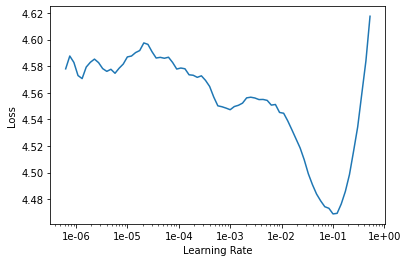

In [9]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [10]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.311600,3.983014,0.296439,00:21
1,3.841139,3.861694,0.305438,00:21
2,3.350481,3.819197,0.311972,00:22
3,3.023856,3.816405,0.313758,00:22


In [11]:
learn.save('fit_head')
learn.load('fit_head')
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.861494,3.844104,0.312561,00:23
1,2.762268,3.840308,0.316416,00:23
2,2.544098,3.860389,0.317766,00:23
3,2.367312,3.883813,0.315909,00:23


In [0]:
learn.save('fine_tuned')
learn.load('fine_tuned');

In [0]:
learn.save_encoder('fine_tuned_enc')

In [15]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [20]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='train_processed.csv',
                                text_cols='TRANS_CONV_TEXT',
                                label_cols='Patient_Tag',
                                vocab = data.vocab,
                                bs=20)

In [21]:
data_clas.show_batch()

text,target
"xxbos xxmaj source xxmaj by xxmaj dr. xxmaj xxunk xxmaj have you checked your vitamin d status lately ? xxmaj ideally , you want to maintain a vitamin d level of 40 to 60 ng / ml year - round . xxmaj based on mounting research , 40 ng / ml appears to be the ? magic ? number at which a whole host of health benefits are xxunk .",0
"xxbos xxmaj canadian xxmaj journal of xxmaj xxunk and xxunk 2016 ( 2016 ) , xxmaj article xxup id xxunk , 6 pages xxmaj research xxmaj article xxmaj split - xxmaj dose xxmaj xxunk xxmaj xxunk xxmaj is xxmaj superior to xxmaj single xxmaj dose for xxmaj colonoscopy xxmaj preparation : xxmaj results of a xxmaj randomized xxmaj controlled xxmaj trial 1 xxmaj division of xxmaj xxunk , xxmaj faculty",0
xxbos xxup must xxup watch xxmaj possible first case of xxup cte diagnosed in the living xxunk xxup cte is football 's xxunk . xxmaj researchers are n't sure exactly what makes some players susceptible to the disease and others not . xxmaj factors such as genetics and age of first impact may play a role . xxmaj but what is clear for many researchers is that it occurs because,0
"xxbos xxmaj photo : xxmaj richard xxmaj shotwell , xxup ap xxmaj image 1 of / 26 26 xxmaj anton xxmaj yelchin arrives at a special screening of "" xxmaj burying the xxmaj ex "" held at xxmaj grauman 's xxmaj egyptian xxmaj theatre in xxmaj los xxmaj angeles . xxmaj yelchin , a charismatic and rising actor best known for playing xxmaj chekov in the new "" xxmaj star",0
"xxbos xxmaj xxunk : xxmaj the xxmaj muscle - xxmaj building , xxmaj brain - xxmaj boosting xxmaj amino xxmaj acid that xxmaj benefits the xxmaj entire xxmaj body xxmaj while you may not be familiar with the term specifically , you use xxunk every day to strengthen your body and , frankly , allow it to work properly . xxmaj this amino acid is essential for many different muscle",0


In [0]:
classifier =text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_tuned_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


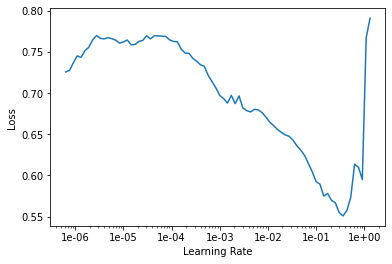

In [28]:
classifier.lr_find()
classifier.recorder.plot()

In [30]:
classifier.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.328951,0.234994,0.905172,00:42


In [31]:
classifier.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.263365,0.326487,0.883621,00:43
1,0.283671,0.257685,0.905172,00:38
2,0.230477,0.265467,0.905172,00:38
3,0.196528,0.255043,0.892241,00:35


In [33]:
classifier.save('first')
classifier.load('first')
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.265683,0.205622,0.909483,00:44


In [34]:
classifier.save('second')
classifier.load('second')
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.189428,0.191874,0.905172,00:42


In [35]:
classifier.save('third')
classifier.load('third')
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.144534,0.193608,0.913793,00:38


In [37]:
classifier.predict('''Hello. I suffer from congestive heart failure due to MI. 
I do have an ICD implant. Have started to experience a weird feeling in middle of chest 
almost like im getting ready to have an annifilactic type reaction a mild anginia I think, 
when this happens my BP monitor registers a low blood pressure, higher heart, and irregular 
heart beat. Breathing is a little more labored and is accompanied by some mild naseua and mild 
light headed. Just had an echo 2 weeks ago and nothing alarming there This very uneasy and 
dreadful feeling. Example of BP reading 83/51 HR 96 and IHB. Cardiologist just tweeked meds to 
see if that would help but no change. Should I contact Cardiologist again. 
Any advice greatly appreciated. Just add a note my heart did
throw a clot that went to my arm about 8 months ago had embolectomy.'''
)

(Category 1, tensor(1), tensor([0.3540, 0.6460]))

In [38]:
classifier.predict('Hi, How are you? It is such a lovely day')

(Category 0, tensor(0), tensor([0.9965, 0.0035]))